# Effect of Different Block Sizes on Access Speed with Zstd and SquashFS

### Notebook Configurations

_Imports_

In [1]:
import os
import time 
import random
import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_Matplotlib Figures Styles_

In [2]:
plt.rcParams['figure.figsize'] = (10, 7) # for the size of matplotlib plots
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = "y"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['grid.color'] = "#EEEEEE"

### Initial Hyphotesis

Small block sizes in compression can result in faster random reads, in this case, in a mounted SquashFS image.

### Initial variables

In the use case of a read-only filesystem (such as SquashFS), the decompression latency is a lot more important than compression latency. Thus, a high compression level for Zstd, which envolves slower compression speed but higher ratios and faster decompression, is optimal. 

* __Zstd compression level:__ 19

In [3]:
compression_level = 19 # high compression level for Zstandard (max is 22)

For this tests, the next files are used:

* __enwik9__: database based on Wikipedia composed of mostly english text in XML encoded with UTF-8. _Total size of file:_ 1GB

In [4]:
file = "enwik9"

For reproducible results, use __42__ as random seed.

In [5]:
random.seed(42)

_Helper functions_

In [6]:
def get_file_size(file):
    
    is_directory = os.popen(f"./is_directory.sh {file}").read().strip() # shell script to check if string corresponds to dir or file
    
    if(is_directory == "1"):
        size = os.popen(f"du -b {file}").read().split("\t")[0]
    else:
        size = os.popen(f"ls -l {file}").read().split(" ")[4]
    
    return int(size)


def get_speed(size, time):
    
    size_in_mb = size / (1024*1024)
    
    return round((size_in_mb/time), 2)


def get_compression_ratio(original, new):
    return original / new


## Effect of block sizes on Access Speed with Zstd and SquashFS

In summary, for each of the 5 block sizes a new SquashFS image is created from the enwik9 file. This image is then mounted in the _/mnt/squashfs-practice mountpoint_ from where it will be randomly accessed a N times. 

The following script calculates the time that it takes to complete the N lookups and stores the results in a Pandas DataFrame.

__Example Compression:__ _mksquashfs FILE FILE.sqsh -comp zstd -Xcompression-level 19 -b BLOCKSIZE_

In [8]:
password = getpass.getpass() # Root user is needed to perform mounting/unmounting

block_sizes = ["4K", "16K", "64K", "256K", "1M"] # different block sizes, powers of 4
NB_LOOKUPS = 10000 # Number of random accesses to the file
NB_RAND_RUNS = 100

df_19 = pd.DataFrame() # new DataFrame to store the data

print(f"--| RANDOM ACCESS TO {file} |--")
 
size_original = get_file_size(file)
filename = file.split(".")[0] # in case file has file format extension

for size in block_sizes:

    print(f"Block size => {size}:")
    
    # -- COMPRESSION PROCESS -- #
    new_file = f"{filename}-{size}"

    compression_command = f"mksquashfs {file} {new_file}.sqsh -comp zstd -Xcompression-level {compression_level} -b {size} > /dev/null"

    # Compress and calculate time
    start_time = time.time()
    os.system(compression_command)
    compression_time = time.time() - start_time

    size_new = get_file_size(f"{new_file}.sqsh")

    # Calc metrics
    compression_ratio = get_compression_ratio(size_original, size_new)
    compression_speed = get_speed(size_original, compression_time)

    # -- MOUNTING PROCESS -- #
    mounting_command = f"sudo -S mount {new_file}.sqsh /mnt/squashfs-practice/ -t squashfs -o loop"
    os.system("echo %s | %s > /dev/null" % (password, mounting_command))

    # -- RANDOM ACCESS PATTERN -- #
    for seed in range(1, NB_RAND_RUNS + 1):    
        # Run C program and capture output
        access_stream = os.popen(f"./read /mnt/squashfs-practice/{filename} {NB_LOOKUPS} {seed}")
        results = access_stream.read().split(" ")
                
        access_time = float(results[0])
        access_sum = results[1]
        
        print(f"  ({seed}) Sum => {access_sum} ; Access Time => {access_time} seconds")
        
        # -- RESULTS STORING -- #
        df_19 = df_19.append({"block_size": size, "access_time": access_time}, ignore_index=True)

        flush_command = 'sudo -S sh -c "echo 1 > /proc/sys/vm/drop_caches"'
        
        os.system(f"sync; echo {password} | {flush_command}") # flush cache to reaload after each mount

    # -- UNMOUNTING PROCESS -- #
    unmounting_command = f"sudo -S umount -l /mnt/squashfs-practice/"
    os.system(f"echo {password} | {unmounting_command}")

os.system(f"ls | grep {filename}- | xargs rm -R") # Code to remove the created files 

········
--| RANDOM ACCESS TO enwik9 |--
Block size => 4K:


[sudo] password for carloscrg19: 

  (1) Sum => 881009 ; Access Time => 0.534 seconds


[sudo] password for carloscrg19: 

  (2) Sum => 882450 ; Access Time => 0.747 seconds


[sudo] password for carloscrg19: 

  (3) Sum => 881389 ; Access Time => 0.745 seconds


[sudo] password for carloscrg19: 

  (4) Sum => 882381 ; Access Time => 0.747 seconds


[sudo] password for carloscrg19: 

  (5) Sum => 881907 ; Access Time => 0.711 seconds


[sudo] password for carloscrg19: 

  (6) Sum => 887973 ; Access Time => 0.694 seconds


[sudo] password for carloscrg19: 

  (7) Sum => 882319 ; Access Time => 0.759 seconds


[sudo] password for carloscrg19: 

  (8) Sum => 882283 ; Access Time => 0.754 seconds


[sudo] password for carloscrg19: 

  (9) Sum => 886572 ; Access Time => 0.705 seconds


[sudo] password for carloscrg19: 

  (10) Sum => 873616 ; Access Time => 0.686 seconds


[sudo] password for carloscrg19: 

  (11) Sum => 881464 ; Access Time => 0.753 seconds


[sudo] password for carloscrg19: 

  (12) Sum => 878293 ; Access Time => 0.695 seconds


[sudo] password for carloscrg19: 

  (13) Sum => 883999 ; Access Time => 0.688 seconds


[sudo] password for carloscrg19: 

  (14) Sum => 885519 ; Access Time => 0.734 seconds


[sudo] password for carloscrg19: 

  (15) Sum => 883108 ; Access Time => 0.705 seconds


[sudo] password for carloscrg19: 

  (16) Sum => 877613 ; Access Time => 0.75 seconds


[sudo] password for carloscrg19: 

  (17) Sum => 884107 ; Access Time => 0.708 seconds


[sudo] password for carloscrg19: 

  (18) Sum => 884452 ; Access Time => 0.728 seconds


[sudo] password for carloscrg19: 

  (19) Sum => 882595 ; Access Time => 0.705 seconds


[sudo] password for carloscrg19: 

  (20) Sum => 882489 ; Access Time => 0.681 seconds


[sudo] password for carloscrg19: 

  (21) Sum => 880589 ; Access Time => 0.721 seconds


[sudo] password for carloscrg19: 

  (22) Sum => 874922 ; Access Time => 0.723 seconds


[sudo] password for carloscrg19: 

  (23) Sum => 878737 ; Access Time => 0.724 seconds


[sudo] password for carloscrg19: 

  (24) Sum => 882483 ; Access Time => 0.749 seconds


[sudo] password for carloscrg19: 

  (25) Sum => 884621 ; Access Time => 0.715 seconds


[sudo] password for carloscrg19: 

  (26) Sum => 882677 ; Access Time => 0.705 seconds


[sudo] password for carloscrg19: 

  (27) Sum => 883283 ; Access Time => 0.737 seconds


[sudo] password for carloscrg19: 

  (28) Sum => 884498 ; Access Time => 0.717 seconds


[sudo] password for carloscrg19: 

  (29) Sum => 882289 ; Access Time => 0.738 seconds


[sudo] password for carloscrg19: 

  (30) Sum => 871242 ; Access Time => 0.735 seconds


[sudo] password for carloscrg19: 

  (31) Sum => 881690 ; Access Time => 0.703 seconds


[sudo] password for carloscrg19: 

  (32) Sum => 881734 ; Access Time => 0.766 seconds


[sudo] password for carloscrg19: 

  (33) Sum => 885439 ; Access Time => 0.729 seconds


[sudo] password for carloscrg19: 

  (34) Sum => 879164 ; Access Time => 0.718 seconds


[sudo] password for carloscrg19: 

  (35) Sum => 880717 ; Access Time => 0.734 seconds


[sudo] password for carloscrg19: 

  (36) Sum => 878335 ; Access Time => 0.734 seconds


[sudo] password for carloscrg19: 

  (37) Sum => 873154 ; Access Time => 0.733 seconds


[sudo] password for carloscrg19: 

  (38) Sum => 879193 ; Access Time => 0.73 seconds


[sudo] password for carloscrg19: 

  (39) Sum => 884035 ; Access Time => 0.734 seconds


[sudo] password for carloscrg19: 

  (40) Sum => 877591 ; Access Time => 0.726 seconds


[sudo] password for carloscrg19: 

  (41) Sum => 883916 ; Access Time => 0.727 seconds


[sudo] password for carloscrg19: 

  (42) Sum => 881009 ; Access Time => 0.704 seconds


[sudo] password for carloscrg19: 

  (43) Sum => 880853 ; Access Time => 0.741 seconds


[sudo] password for carloscrg19: 

  (44) Sum => 875575 ; Access Time => 0.699 seconds


[sudo] password for carloscrg19: 

  (45) Sum => 882040 ; Access Time => 0.748 seconds


[sudo] password for carloscrg19: 

  (46) Sum => 881661 ; Access Time => 0.75 seconds


[sudo] password for carloscrg19: 

  (47) Sum => 884328 ; Access Time => 0.752 seconds


[sudo] password for carloscrg19: 

  (48) Sum => 883289 ; Access Time => 0.708 seconds


[sudo] password for carloscrg19: 

  (49) Sum => 879453 ; Access Time => 0.751 seconds


[sudo] password for carloscrg19: 

  (50) Sum => 879768 ; Access Time => 0.714 seconds


[sudo] password for carloscrg19: 

  (51) Sum => 881314 ; Access Time => 0.737 seconds


[sudo] password for carloscrg19: 

  (52) Sum => 881124 ; Access Time => 0.724 seconds


[sudo] password for carloscrg19: 

  (53) Sum => 881310 ; Access Time => 0.707 seconds


[sudo] password for carloscrg19: 

  (54) Sum => 879402 ; Access Time => 0.732 seconds


[sudo] password for carloscrg19: 

  (55) Sum => 877691 ; Access Time => 0.761 seconds


[sudo] password for carloscrg19: 

  (56) Sum => 876618 ; Access Time => 0.725 seconds


[sudo] password for carloscrg19: 

  (57) Sum => 883312 ; Access Time => 0.742 seconds


[sudo] password for carloscrg19: 

  (58) Sum => 874701 ; Access Time => 0.714 seconds


[sudo] password for carloscrg19: 

  (59) Sum => 881464 ; Access Time => 0.739 seconds


[sudo] password for carloscrg19: 

  (60) Sum => 882510 ; Access Time => 0.735 seconds


[sudo] password for carloscrg19: 

  (61) Sum => 879999 ; Access Time => 0.718 seconds


[sudo] password for carloscrg19: 

  (62) Sum => 884621 ; Access Time => 0.695 seconds


[sudo] password for carloscrg19: 

  (63) Sum => 882489 ; Access Time => 0.713 seconds


[sudo] password for carloscrg19: 

  (64) Sum => 878117 ; Access Time => 0.733 seconds


[sudo] password for carloscrg19: 

  (65) Sum => 878990 ; Access Time => 0.732 seconds


[sudo] password for carloscrg19: 

  (66) Sum => 886088 ; Access Time => 0.714 seconds


[sudo] password for carloscrg19: 

  (67) Sum => 874992 ; Access Time => 0.7 seconds


[sudo] password for carloscrg19: 

  (68) Sum => 878202 ; Access Time => 0.726 seconds


[sudo] password for carloscrg19: 

  (69) Sum => 882919 ; Access Time => 0.705 seconds


[sudo] password for carloscrg19: 

  (70) Sum => 883504 ; Access Time => 0.738 seconds


[sudo] password for carloscrg19: 

  (71) Sum => 882083 ; Access Time => 0.706 seconds


[sudo] password for carloscrg19: 

  (72) Sum => 877911 ; Access Time => 0.704 seconds


[sudo] password for carloscrg19: 

  (73) Sum => 879443 ; Access Time => 0.737 seconds


[sudo] password for carloscrg19: 

  (74) Sum => 881430 ; Access Time => 0.703 seconds


[sudo] password for carloscrg19: 

  (75) Sum => 880029 ; Access Time => 0.723 seconds


[sudo] password for carloscrg19: 

  (76) Sum => 875563 ; Access Time => 0.717 seconds


[sudo] password for carloscrg19: 

  (77) Sum => 879459 ; Access Time => 0.732 seconds


[sudo] password for carloscrg19: 

  (78) Sum => 880000 ; Access Time => 0.719 seconds


[sudo] password for carloscrg19: 

  (79) Sum => 884868 ; Access Time => 0.716 seconds


[sudo] password for carloscrg19: 

  (80) Sum => 880586 ; Access Time => 0.699 seconds


[sudo] password for carloscrg19: 

  (81) Sum => 879638 ; Access Time => 0.759 seconds


[sudo] password for carloscrg19: 

  (82) Sum => 883033 ; Access Time => 0.71 seconds


[sudo] password for carloscrg19: 

  (83) Sum => 883287 ; Access Time => 0.746 seconds


[sudo] password for carloscrg19: 

  (84) Sum => 878711 ; Access Time => 0.719 seconds


[sudo] password for carloscrg19: 

  (85) Sum => 877294 ; Access Time => 0.71 seconds


[sudo] password for carloscrg19: 

  (86) Sum => 884438 ; Access Time => 0.748 seconds


[sudo] password for carloscrg19: 

  (87) Sum => 885536 ; Access Time => 0.733 seconds


[sudo] password for carloscrg19: 

  (88) Sum => 876025 ; Access Time => 0.77 seconds


[sudo] password for carloscrg19: 

  (89) Sum => 877273 ; Access Time => 0.744 seconds


[sudo] password for carloscrg19: 

  (90) Sum => 886376 ; Access Time => 0.713 seconds


[sudo] password for carloscrg19: 

  (91) Sum => 884462 ; Access Time => 0.733 seconds


[sudo] password for carloscrg19: 

  (92) Sum => 878782 ; Access Time => 0.741 seconds


[sudo] password for carloscrg19: 

  (93) Sum => 882029 ; Access Time => 0.71 seconds


[sudo] password for carloscrg19: 

  (94) Sum => 882758 ; Access Time => 0.679 seconds


[sudo] password for carloscrg19: 

  (95) Sum => 881461 ; Access Time => 0.684 seconds


[sudo] password for carloscrg19: 

  (96) Sum => 880927 ; Access Time => 0.695 seconds


[sudo] password for carloscrg19: 

  (97) Sum => 880460 ; Access Time => 0.733 seconds


[sudo] password for carloscrg19: 

  (98) Sum => 877499 ; Access Time => 0.727 seconds


[sudo] password for carloscrg19: 

  (99) Sum => 883472 ; Access Time => 0.759 seconds


[sudo] password for carloscrg19: 

  (100) Sum => 883219 ; Access Time => 0.733 seconds


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Block size => 16K:


[sudo] password for carloscrg19: 

  (1) Sum => 881009 ; Access Time => 0.685 seconds


[sudo] password for carloscrg19: 

  (2) Sum => 882450 ; Access Time => 0.843 seconds


[sudo] password for carloscrg19: 

  (3) Sum => 881389 ; Access Time => 0.865 seconds


[sudo] password for carloscrg19: 

  (4) Sum => 882381 ; Access Time => 0.872 seconds


[sudo] password for carloscrg19: 

  (5) Sum => 881907 ; Access Time => 0.838 seconds


[sudo] password for carloscrg19: 

  (6) Sum => 887973 ; Access Time => 0.859 seconds


[sudo] password for carloscrg19: 

  (7) Sum => 882319 ; Access Time => 0.923 seconds


[sudo] password for carloscrg19: 

  (8) Sum => 882283 ; Access Time => 0.837 seconds


[sudo] password for carloscrg19: 

  (9) Sum => 886572 ; Access Time => 0.878 seconds


[sudo] password for carloscrg19: 

  (10) Sum => 873616 ; Access Time => 0.878 seconds


[sudo] password for carloscrg19: 

  (11) Sum => 881464 ; Access Time => 0.889 seconds


[sudo] password for carloscrg19: 

  (12) Sum => 878293 ; Access Time => 0.872 seconds


[sudo] password for carloscrg19: 

  (13) Sum => 883999 ; Access Time => 0.821 seconds


[sudo] password for carloscrg19: 

  (14) Sum => 885519 ; Access Time => 0.809 seconds


[sudo] password for carloscrg19: 

  (15) Sum => 883108 ; Access Time => 0.834 seconds


[sudo] password for carloscrg19: 

  (16) Sum => 877613 ; Access Time => 0.815 seconds


[sudo] password for carloscrg19: 

  (17) Sum => 884107 ; Access Time => 0.866 seconds


[sudo] password for carloscrg19: 

  (18) Sum => 884452 ; Access Time => 0.874 seconds


[sudo] password for carloscrg19: 

  (19) Sum => 882595 ; Access Time => 0.828 seconds


[sudo] password for carloscrg19: 

  (20) Sum => 882489 ; Access Time => 0.877 seconds


[sudo] password for carloscrg19: 

  (21) Sum => 880589 ; Access Time => 0.863 seconds


[sudo] password for carloscrg19: 

  (22) Sum => 874922 ; Access Time => 0.844 seconds


[sudo] password for carloscrg19: 

  (23) Sum => 878737 ; Access Time => 0.884 seconds


[sudo] password for carloscrg19: 

  (24) Sum => 882483 ; Access Time => 0.835 seconds


[sudo] password for carloscrg19: 

  (25) Sum => 884621 ; Access Time => 0.835 seconds


[sudo] password for carloscrg19: 

  (26) Sum => 882677 ; Access Time => 0.875 seconds


[sudo] password for carloscrg19: 

  (27) Sum => 883283 ; Access Time => 0.867 seconds


[sudo] password for carloscrg19: 

  (28) Sum => 884498 ; Access Time => 0.856 seconds


[sudo] password for carloscrg19: 

  (29) Sum => 882289 ; Access Time => 0.87 seconds


[sudo] password for carloscrg19: 

  (30) Sum => 871242 ; Access Time => 0.847 seconds


[sudo] password for carloscrg19: 

  (31) Sum => 881690 ; Access Time => 0.857 seconds


[sudo] password for carloscrg19: 

  (32) Sum => 881734 ; Access Time => 0.827 seconds


[sudo] password for carloscrg19: 

  (33) Sum => 885439 ; Access Time => 0.84 seconds


[sudo] password for carloscrg19: 

  (34) Sum => 879164 ; Access Time => 0.85 seconds


[sudo] password for carloscrg19: 

  (35) Sum => 880717 ; Access Time => 0.91 seconds


[sudo] password for carloscrg19: 

  (36) Sum => 878335 ; Access Time => 0.86 seconds


[sudo] password for carloscrg19: 

  (37) Sum => 873154 ; Access Time => 0.85 seconds


[sudo] password for carloscrg19: 

  (38) Sum => 879193 ; Access Time => 0.858 seconds


[sudo] password for carloscrg19: 

  (39) Sum => 884035 ; Access Time => 0.841 seconds


[sudo] password for carloscrg19: 

  (40) Sum => 877591 ; Access Time => 0.834 seconds


[sudo] password for carloscrg19: 

  (41) Sum => 883916 ; Access Time => 0.874 seconds


[sudo] password for carloscrg19: 

  (42) Sum => 881009 ; Access Time => 0.87 seconds


[sudo] password for carloscrg19: 

  (43) Sum => 880853 ; Access Time => 0.855 seconds


[sudo] password for carloscrg19: 

  (44) Sum => 875575 ; Access Time => 0.899 seconds


[sudo] password for carloscrg19: 

  (45) Sum => 882040 ; Access Time => 0.86 seconds


[sudo] password for carloscrg19: 

  (46) Sum => 881661 ; Access Time => 0.918 seconds


[sudo] password for carloscrg19: 

  (47) Sum => 884328 ; Access Time => 0.859 seconds


[sudo] password for carloscrg19: 

  (48) Sum => 883289 ; Access Time => 0.845 seconds


[sudo] password for carloscrg19: 

  (49) Sum => 879453 ; Access Time => 0.866 seconds


[sudo] password for carloscrg19: 

  (50) Sum => 879768 ; Access Time => 0.861 seconds


[sudo] password for carloscrg19: 

  (51) Sum => 881314 ; Access Time => 0.872 seconds


[sudo] password for carloscrg19: 

  (52) Sum => 881124 ; Access Time => 0.81 seconds


[sudo] password for carloscrg19: 

  (53) Sum => 881310 ; Access Time => 0.897 seconds


[sudo] password for carloscrg19: 

  (54) Sum => 879402 ; Access Time => 0.839 seconds


[sudo] password for carloscrg19: 

  (55) Sum => 877691 ; Access Time => 0.879 seconds


[sudo] password for carloscrg19: 

  (56) Sum => 876618 ; Access Time => 0.845 seconds


[sudo] password for carloscrg19: 

  (57) Sum => 883312 ; Access Time => 0.853 seconds


[sudo] password for carloscrg19: 

  (58) Sum => 874701 ; Access Time => 0.844 seconds


[sudo] password for carloscrg19: 

  (59) Sum => 881464 ; Access Time => 0.821 seconds


[sudo] password for carloscrg19: 

  (60) Sum => 882510 ; Access Time => 0.86 seconds


[sudo] password for carloscrg19: 

  (61) Sum => 879999 ; Access Time => 0.872 seconds


[sudo] password for carloscrg19: 

  (62) Sum => 884621 ; Access Time => 0.854 seconds


[sudo] password for carloscrg19: 

  (63) Sum => 882489 ; Access Time => 0.895 seconds


[sudo] password for carloscrg19: 

  (64) Sum => 878117 ; Access Time => 0.813 seconds


[sudo] password for carloscrg19: 

  (65) Sum => 878990 ; Access Time => 0.866 seconds


[sudo] password for carloscrg19: 

  (66) Sum => 886088 ; Access Time => 0.852 seconds


[sudo] password for carloscrg19: 

  (67) Sum => 874992 ; Access Time => 0.831 seconds


[sudo] password for carloscrg19: 

  (68) Sum => 878202 ; Access Time => 0.847 seconds


[sudo] password for carloscrg19: 

  (69) Sum => 882919 ; Access Time => 0.85 seconds


[sudo] password for carloscrg19: 

  (70) Sum => 883504 ; Access Time => 0.87 seconds


[sudo] password for carloscrg19: 

  (71) Sum => 882083 ; Access Time => 0.815 seconds


[sudo] password for carloscrg19: 

  (72) Sum => 877911 ; Access Time => 0.85 seconds


[sudo] password for carloscrg19: 

  (73) Sum => 879443 ; Access Time => 0.857 seconds


[sudo] password for carloscrg19: 

  (74) Sum => 881430 ; Access Time => 0.864 seconds


[sudo] password for carloscrg19: 

  (75) Sum => 880029 ; Access Time => 0.856 seconds


[sudo] password for carloscrg19: 

  (76) Sum => 875563 ; Access Time => 0.852 seconds


[sudo] password for carloscrg19: 

  (77) Sum => 879459 ; Access Time => 0.805 seconds


[sudo] password for carloscrg19: 

  (78) Sum => 880000 ; Access Time => 0.889 seconds


[sudo] password for carloscrg19: 

  (79) Sum => 884868 ; Access Time => 0.845 seconds


[sudo] password for carloscrg19: 

  (80) Sum => 880586 ; Access Time => 0.857 seconds


[sudo] password for carloscrg19: 

  (81) Sum => 879638 ; Access Time => 0.817 seconds


[sudo] password for carloscrg19: 

  (82) Sum => 883033 ; Access Time => 0.843 seconds


[sudo] password for carloscrg19: 

  (83) Sum => 883287 ; Access Time => 0.858 seconds


[sudo] password for carloscrg19: 

  (84) Sum => 878711 ; Access Time => 0.892 seconds


[sudo] password for carloscrg19: 

  (85) Sum => 877294 ; Access Time => 0.839 seconds


[sudo] password for carloscrg19: 

  (86) Sum => 884438 ; Access Time => 0.835 seconds


[sudo] password for carloscrg19: 

  (87) Sum => 885536 ; Access Time => 0.86 seconds


[sudo] password for carloscrg19: 

  (88) Sum => 876025 ; Access Time => 0.831 seconds


[sudo] password for carloscrg19: 

  (89) Sum => 877273 ; Access Time => 0.882 seconds


[sudo] password for carloscrg19: 

  (90) Sum => 886376 ; Access Time => 0.863 seconds


[sudo] password for carloscrg19: 

  (91) Sum => 884462 ; Access Time => 0.889 seconds


[sudo] password for carloscrg19: 

  (92) Sum => 878782 ; Access Time => 0.846 seconds


[sudo] password for carloscrg19: 

  (93) Sum => 882029 ; Access Time => 0.862 seconds


[sudo] password for carloscrg19: 

  (94) Sum => 882758 ; Access Time => 0.854 seconds


[sudo] password for carloscrg19: 

  (95) Sum => 881461 ; Access Time => 0.85 seconds


[sudo] password for carloscrg19: 

  (96) Sum => 880927 ; Access Time => 0.861 seconds


[sudo] password for carloscrg19: 

  (97) Sum => 880460 ; Access Time => 0.848 seconds


[sudo] password for carloscrg19: 

  (98) Sum => 877499 ; Access Time => 0.827 seconds


[sudo] password for carloscrg19: 

  (99) Sum => 883472 ; Access Time => 0.877 seconds


[sudo] password for carloscrg19: 

  (100) Sum => 883219 ; Access Time => 0.859 seconds


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Block size => 64K:


[sudo] password for carloscrg19: 

  (1) Sum => 881009 ; Access Time => 1.001 seconds


[sudo] password for carloscrg19: 

  (2) Sum => 882450 ; Access Time => 1.077 seconds


[sudo] password for carloscrg19: 

  (3) Sum => 881389 ; Access Time => 1.152 seconds


[sudo] password for carloscrg19: 

  (4) Sum => 882381 ; Access Time => 1.094 seconds


[sudo] password for carloscrg19: 

  (5) Sum => 881907 ; Access Time => 1.091 seconds


[sudo] password for carloscrg19: 

  (6) Sum => 887973 ; Access Time => 1.235 seconds


[sudo] password for carloscrg19: 

  (7) Sum => 882319 ; Access Time => 1.069 seconds


[sudo] password for carloscrg19: 

  (8) Sum => 882283 ; Access Time => 1.078 seconds


[sudo] password for carloscrg19: 

  (9) Sum => 886572 ; Access Time => 1.136 seconds


[sudo] password for carloscrg19: 

  (10) Sum => 873616 ; Access Time => 1.071 seconds


[sudo] password for carloscrg19: 

  (11) Sum => 881464 ; Access Time => 1.034 seconds


[sudo] password for carloscrg19: 

  (12) Sum => 878293 ; Access Time => 1.031 seconds


[sudo] password for carloscrg19: 

  (13) Sum => 883999 ; Access Time => 1.075 seconds


[sudo] password for carloscrg19: 

  (14) Sum => 885519 ; Access Time => 1.086 seconds


[sudo] password for carloscrg19: 

  (15) Sum => 883108 ; Access Time => 1.114 seconds


[sudo] password for carloscrg19: 

  (16) Sum => 877613 ; Access Time => 1.084 seconds


[sudo] password for carloscrg19: 

  (17) Sum => 884107 ; Access Time => 1.073 seconds


[sudo] password for carloscrg19: 

  (18) Sum => 884452 ; Access Time => 1.082 seconds


[sudo] password for carloscrg19: 

  (19) Sum => 882595 ; Access Time => 1.073 seconds


[sudo] password for carloscrg19: 

  (20) Sum => 882489 ; Access Time => 1.045 seconds


[sudo] password for carloscrg19: 

  (21) Sum => 880589 ; Access Time => 1.074 seconds


[sudo] password for carloscrg19: 

  (22) Sum => 874922 ; Access Time => 1.092 seconds


[sudo] password for carloscrg19: 

  (23) Sum => 878737 ; Access Time => 1.094 seconds


[sudo] password for carloscrg19: 

  (24) Sum => 882483 ; Access Time => 1.058 seconds


[sudo] password for carloscrg19: 

  (25) Sum => 884621 ; Access Time => 1.09 seconds


[sudo] password for carloscrg19: 

  (26) Sum => 882677 ; Access Time => 1.065 seconds


[sudo] password for carloscrg19: 

  (27) Sum => 883283 ; Access Time => 1.066 seconds


[sudo] password for carloscrg19: 

  (28) Sum => 884498 ; Access Time => 1.021 seconds


[sudo] password for carloscrg19: 

  (29) Sum => 882289 ; Access Time => 1.112 seconds


[sudo] password for carloscrg19: 

  (30) Sum => 871242 ; Access Time => 1.065 seconds


[sudo] password for carloscrg19: 

  (31) Sum => 881690 ; Access Time => 1.082 seconds


[sudo] password for carloscrg19: 

  (32) Sum => 881734 ; Access Time => 1.077 seconds


[sudo] password for carloscrg19: 

  (33) Sum => 885439 ; Access Time => 1.105 seconds


[sudo] password for carloscrg19: 

  (34) Sum => 879164 ; Access Time => 1.07 seconds


[sudo] password for carloscrg19: 

  (35) Sum => 880717 ; Access Time => 1.062 seconds


[sudo] password for carloscrg19: 

  (36) Sum => 878335 ; Access Time => 1.09 seconds


[sudo] password for carloscrg19: 

  (37) Sum => 873154 ; Access Time => 1.038 seconds


[sudo] password for carloscrg19: 

  (38) Sum => 879193 ; Access Time => 1.14 seconds


[sudo] password for carloscrg19: 

  (39) Sum => 884035 ; Access Time => 1.062 seconds


[sudo] password for carloscrg19: 

  (40) Sum => 877591 ; Access Time => 1.078 seconds


[sudo] password for carloscrg19: 

  (41) Sum => 883916 ; Access Time => 1.107 seconds


[sudo] password for carloscrg19: 

  (42) Sum => 881009 ; Access Time => 1.13 seconds


[sudo] password for carloscrg19: 

  (43) Sum => 880853 ; Access Time => 1.073 seconds


[sudo] password for carloscrg19: 

  (44) Sum => 875575 ; Access Time => 1.112 seconds


[sudo] password for carloscrg19: 

  (45) Sum => 882040 ; Access Time => 1.086 seconds


[sudo] password for carloscrg19: 

  (46) Sum => 881661 ; Access Time => 1.056 seconds


[sudo] password for carloscrg19: 

  (47) Sum => 884328 ; Access Time => 1.075 seconds


[sudo] password for carloscrg19: 

  (48) Sum => 883289 ; Access Time => 1.159 seconds


[sudo] password for carloscrg19: 

  (49) Sum => 879453 ; Access Time => 1.068 seconds


[sudo] password for carloscrg19: 

  (50) Sum => 879768 ; Access Time => 1.091 seconds


[sudo] password for carloscrg19: 

  (51) Sum => 881314 ; Access Time => 1.102 seconds


[sudo] password for carloscrg19: 

  (52) Sum => 881124 ; Access Time => 1.066 seconds


[sudo] password for carloscrg19: 

  (53) Sum => 881310 ; Access Time => 1.053 seconds


[sudo] password for carloscrg19: 

  (54) Sum => 879402 ; Access Time => 1.076 seconds


[sudo] password for carloscrg19: 

  (55) Sum => 877691 ; Access Time => 1.073 seconds


[sudo] password for carloscrg19: 

  (56) Sum => 876618 ; Access Time => 1.057 seconds


[sudo] password for carloscrg19: 

  (57) Sum => 883312 ; Access Time => 1.047 seconds


[sudo] password for carloscrg19: 

  (58) Sum => 874701 ; Access Time => 1.061 seconds


[sudo] password for carloscrg19: 

  (59) Sum => 881464 ; Access Time => 1.074 seconds


[sudo] password for carloscrg19: 

  (60) Sum => 882510 ; Access Time => 1.089 seconds


[sudo] password for carloscrg19: 

  (61) Sum => 879999 ; Access Time => 1.059 seconds


[sudo] password for carloscrg19: 

  (62) Sum => 884621 ; Access Time => 1.045 seconds


[sudo] password for carloscrg19: 

  (63) Sum => 882489 ; Access Time => 1.03 seconds


[sudo] password for carloscrg19: 

  (64) Sum => 878117 ; Access Time => 1.08 seconds


[sudo] password for carloscrg19: 

  (65) Sum => 878990 ; Access Time => 1.086 seconds


[sudo] password for carloscrg19: 

  (66) Sum => 886088 ; Access Time => 1.101 seconds


[sudo] password for carloscrg19: 

  (67) Sum => 874992 ; Access Time => 1.081 seconds


[sudo] password for carloscrg19: 

  (68) Sum => 878202 ; Access Time => 1.063 seconds


[sudo] password for carloscrg19: 

  (69) Sum => 882919 ; Access Time => 1.058 seconds


[sudo] password for carloscrg19: 

  (70) Sum => 883504 ; Access Time => 1.081 seconds


[sudo] password for carloscrg19: 

  (71) Sum => 882083 ; Access Time => 1.053 seconds


[sudo] password for carloscrg19: 

  (72) Sum => 877911 ; Access Time => 1.061 seconds


[sudo] password for carloscrg19: 

  (73) Sum => 879443 ; Access Time => 1.074 seconds


[sudo] password for carloscrg19: 

  (74) Sum => 881430 ; Access Time => 1.024 seconds


[sudo] password for carloscrg19: 

  (75) Sum => 880029 ; Access Time => 1.052 seconds


[sudo] password for carloscrg19: 

  (76) Sum => 875563 ; Access Time => 1.107 seconds


[sudo] password for carloscrg19: 

  (77) Sum => 879459 ; Access Time => 1.152 seconds


[sudo] password for carloscrg19: 

  (78) Sum => 880000 ; Access Time => 1.146 seconds


[sudo] password for carloscrg19: 

  (79) Sum => 884868 ; Access Time => 1.193 seconds


[sudo] password for carloscrg19: 

  (80) Sum => 880586 ; Access Time => 1.144 seconds


[sudo] password for carloscrg19: 

  (81) Sum => 879638 ; Access Time => 1.128 seconds


[sudo] password for carloscrg19: 

  (82) Sum => 883033 ; Access Time => 1.123 seconds


[sudo] password for carloscrg19: 

  (83) Sum => 883287 ; Access Time => 1.143 seconds


[sudo] password for carloscrg19: 

  (84) Sum => 878711 ; Access Time => 1.174 seconds


[sudo] password for carloscrg19: 

  (85) Sum => 877294 ; Access Time => 1.108 seconds


[sudo] password for carloscrg19: 

  (86) Sum => 884438 ; Access Time => 1.128 seconds


[sudo] password for carloscrg19: 

  (87) Sum => 885536 ; Access Time => 1.067 seconds


[sudo] password for carloscrg19: 

  (88) Sum => 876025 ; Access Time => 1.028 seconds


[sudo] password for carloscrg19: 

  (89) Sum => 877273 ; Access Time => 1.055 seconds


[sudo] password for carloscrg19: 

  (90) Sum => 886376 ; Access Time => 1.033 seconds


[sudo] password for carloscrg19: 

  (91) Sum => 884462 ; Access Time => 1.07 seconds


[sudo] password for carloscrg19: 

  (92) Sum => 878782 ; Access Time => 1.083 seconds


[sudo] password for carloscrg19: 

  (93) Sum => 882029 ; Access Time => 1.099 seconds


[sudo] password for carloscrg19: 

  (94) Sum => 882758 ; Access Time => 1.072 seconds


[sudo] password for carloscrg19: 

  (95) Sum => 881461 ; Access Time => 1.087 seconds


[sudo] password for carloscrg19: 

  (96) Sum => 880927 ; Access Time => 1.08 seconds


[sudo] password for carloscrg19: 

  (97) Sum => 880460 ; Access Time => 1.055 seconds


[sudo] password for carloscrg19: 

  (98) Sum => 877499 ; Access Time => 1.088 seconds


[sudo] password for carloscrg19: 

  (99) Sum => 883472 ; Access Time => 1.066 seconds


[sudo] password for carloscrg19: 

  (100) Sum => 883219 ; Access Time => 1.07 seconds


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Block size => 256K:


[sudo] password for carloscrg19: 

  (1) Sum => 881009 ; Access Time => 1.697 seconds


[sudo] password for carloscrg19: 

  (2) Sum => 882450 ; Access Time => 2.365 seconds


[sudo] password for carloscrg19: 

  (3) Sum => 881389 ; Access Time => 2.821 seconds


[sudo] password for carloscrg19: 

  (4) Sum => 882381 ; Access Time => 2.058 seconds


[sudo] password for carloscrg19: 

  (5) Sum => 881907 ; Access Time => 1.776 seconds


[sudo] password for carloscrg19: 

  (6) Sum => 887973 ; Access Time => 1.858 seconds


[sudo] password for carloscrg19: 

  (7) Sum => 882319 ; Access Time => 2.635 seconds


[sudo] password for carloscrg19: 

  (8) Sum => 882283 ; Access Time => 2.963 seconds


[sudo] password for carloscrg19: 

  (9) Sum => 886572 ; Access Time => 1.678 seconds


[sudo] password for carloscrg19: 

  (10) Sum => 873616 ; Access Time => 2.414 seconds


[sudo] password for carloscrg19: 

  (11) Sum => 881464 ; Access Time => 1.819 seconds


[sudo] password for carloscrg19: 

  (12) Sum => 878293 ; Access Time => 1.858 seconds


[sudo] password for carloscrg19: 

  (13) Sum => 883999 ; Access Time => 3.057 seconds


[sudo] password for carloscrg19: 

  (14) Sum => 885519 ; Access Time => 1.669 seconds


[sudo] password for carloscrg19: 

  (15) Sum => 883108 ; Access Time => 1.916 seconds


[sudo] password for carloscrg19: 

  (16) Sum => 877613 ; Access Time => 2.505 seconds


[sudo] password for carloscrg19: 

  (17) Sum => 884107 ; Access Time => 2.209 seconds


[sudo] password for carloscrg19: 

  (18) Sum => 884452 ; Access Time => 1.633 seconds


[sudo] password for carloscrg19: 

  (19) Sum => 882595 ; Access Time => 1.804 seconds


[sudo] password for carloscrg19: 

  (20) Sum => 882489 ; Access Time => 2.049 seconds


[sudo] password for carloscrg19: 

  (21) Sum => 880589 ; Access Time => 1.789 seconds


[sudo] password for carloscrg19: 

  (22) Sum => 874922 ; Access Time => 1.682 seconds


[sudo] password for carloscrg19: 

  (23) Sum => 878737 ; Access Time => 2.69 seconds


[sudo] password for carloscrg19: 

  (24) Sum => 882483 ; Access Time => 1.925 seconds


[sudo] password for carloscrg19: 

  (25) Sum => 884621 ; Access Time => 1.601 seconds


[sudo] password for carloscrg19: 

  (26) Sum => 882677 ; Access Time => 1.924 seconds


[sudo] password for carloscrg19: 

  (27) Sum => 883283 ; Access Time => 1.644 seconds


[sudo] password for carloscrg19: 

  (28) Sum => 884498 ; Access Time => 2.795 seconds


[sudo] password for carloscrg19: 

  (29) Sum => 882289 ; Access Time => 1.731 seconds


[sudo] password for carloscrg19: 

  (30) Sum => 871242 ; Access Time => 1.64 seconds


[sudo] password for carloscrg19: 

  (31) Sum => 881690 ; Access Time => 2.821 seconds


[sudo] password for carloscrg19: 

  (32) Sum => 881734 ; Access Time => 2.519 seconds


[sudo] password for carloscrg19: 

  (33) Sum => 885439 ; Access Time => 1.949 seconds


[sudo] password for carloscrg19: 

  (34) Sum => 879164 ; Access Time => 1.708 seconds


[sudo] password for carloscrg19: 

  (35) Sum => 880717 ; Access Time => 1.751 seconds


[sudo] password for carloscrg19: 

  (36) Sum => 878335 ; Access Time => 2.601 seconds


[sudo] password for carloscrg19: 

  (37) Sum => 873154 ; Access Time => 1.843 seconds


[sudo] password for carloscrg19: 

  (38) Sum => 879193 ; Access Time => 1.78 seconds


[sudo] password for carloscrg19: 

  (39) Sum => 884035 ; Access Time => 2.408 seconds


[sudo] password for carloscrg19: 

  (40) Sum => 877591 ; Access Time => 1.726 seconds


[sudo] password for carloscrg19: 

  (41) Sum => 883916 ; Access Time => 1.737 seconds


[sudo] password for carloscrg19: 

  (42) Sum => 881009 ; Access Time => 1.616 seconds


[sudo] password for carloscrg19: 

  (43) Sum => 880853 ; Access Time => 1.853 seconds


[sudo] password for carloscrg19: 

  (44) Sum => 875575 ; Access Time => 2.456 seconds


[sudo] password for carloscrg19: 

  (45) Sum => 882040 ; Access Time => 1.792 seconds


[sudo] password for carloscrg19: 

  (46) Sum => 881661 ; Access Time => 1.769 seconds


[sudo] password for carloscrg19: 

  (47) Sum => 884328 ; Access Time => 1.624 seconds


[sudo] password for carloscrg19: 

  (48) Sum => 883289 ; Access Time => 1.611 seconds


[sudo] password for carloscrg19: 

  (49) Sum => 879453 ; Access Time => 2.563 seconds


[sudo] password for carloscrg19: 

  (50) Sum => 879768 ; Access Time => 1.707 seconds


[sudo] password for carloscrg19: 

  (51) Sum => 881314 ; Access Time => 2.619 seconds


[sudo] password for carloscrg19: 

  (52) Sum => 881124 ; Access Time => 2.126 seconds


[sudo] password for carloscrg19: 

  (53) Sum => 881310 ; Access Time => 1.7 seconds


[sudo] password for carloscrg19: 

  (54) Sum => 879402 ; Access Time => 2.087 seconds


[sudo] password for carloscrg19: 

  (55) Sum => 877691 ; Access Time => 2.457 seconds


[sudo] password for carloscrg19: 

  (56) Sum => 876618 ; Access Time => 2.794 seconds


[sudo] password for carloscrg19: 

  (57) Sum => 883312 ; Access Time => 1.905 seconds


[sudo] password for carloscrg19: 

  (58) Sum => 874701 ; Access Time => 2.501 seconds


[sudo] password for carloscrg19: 

  (59) Sum => 881464 ; Access Time => 1.673 seconds


[sudo] password for carloscrg19: 

  (60) Sum => 882510 ; Access Time => 2.797 seconds


[sudo] password for carloscrg19: 

  (61) Sum => 879999 ; Access Time => 2.433 seconds


[sudo] password for carloscrg19: 

  (62) Sum => 884621 ; Access Time => 2.475 seconds


[sudo] password for carloscrg19: 

  (63) Sum => 882489 ; Access Time => 2.623 seconds


[sudo] password for carloscrg19: 

  (64) Sum => 878117 ; Access Time => 2.662 seconds


[sudo] password for carloscrg19: 

  (65) Sum => 878990 ; Access Time => 2.19 seconds


[sudo] password for carloscrg19: 

  (66) Sum => 886088 ; Access Time => 1.708 seconds


[sudo] password for carloscrg19: 

  (67) Sum => 874992 ; Access Time => 2.518 seconds


[sudo] password for carloscrg19: 

  (68) Sum => 878202 ; Access Time => 1.682 seconds


[sudo] password for carloscrg19: 

  (69) Sum => 882919 ; Access Time => 1.801 seconds


[sudo] password for carloscrg19: 

  (70) Sum => 883504 ; Access Time => 2.762 seconds


[sudo] password for carloscrg19: 

  (71) Sum => 882083 ; Access Time => 1.751 seconds


[sudo] password for carloscrg19: 

  (72) Sum => 877911 ; Access Time => 1.75 seconds


[sudo] password for carloscrg19: 

  (73) Sum => 879443 ; Access Time => 1.652 seconds


[sudo] password for carloscrg19: 

  (74) Sum => 881430 ; Access Time => 2.505 seconds


[sudo] password for carloscrg19: 

  (75) Sum => 880029 ; Access Time => 1.614 seconds


[sudo] password for carloscrg19: 

  (76) Sum => 875563 ; Access Time => 2.221 seconds


[sudo] password for carloscrg19: 

  (77) Sum => 879459 ; Access Time => 2.759 seconds


[sudo] password for carloscrg19: 

  (78) Sum => 880000 ; Access Time => 2.725 seconds


[sudo] password for carloscrg19: 

  (79) Sum => 884868 ; Access Time => 1.75 seconds


[sudo] password for carloscrg19: 

  (80) Sum => 880586 ; Access Time => 1.786 seconds


[sudo] password for carloscrg19: 

  (81) Sum => 879638 ; Access Time => 1.62 seconds


[sudo] password for carloscrg19: 

  (82) Sum => 883033 ; Access Time => 2.866 seconds


[sudo] password for carloscrg19: 

  (83) Sum => 883287 ; Access Time => 1.763 seconds


[sudo] password for carloscrg19: 

  (84) Sum => 878711 ; Access Time => 2.703 seconds


[sudo] password for carloscrg19: 

  (85) Sum => 877294 ; Access Time => 2.275 seconds


[sudo] password for carloscrg19: 

  (86) Sum => 884438 ; Access Time => 2.826 seconds


[sudo] password for carloscrg19: 

  (87) Sum => 885536 ; Access Time => 2.835 seconds


[sudo] password for carloscrg19: 

  (88) Sum => 876025 ; Access Time => 1.678 seconds


[sudo] password for carloscrg19: 

  (89) Sum => 877273 ; Access Time => 2.216 seconds


[sudo] password for carloscrg19: 

  (90) Sum => 886376 ; Access Time => 2.797 seconds


[sudo] password for carloscrg19: 

  (91) Sum => 884462 ; Access Time => 2.517 seconds


[sudo] password for carloscrg19: 

  (92) Sum => 878782 ; Access Time => 1.637 seconds


[sudo] password for carloscrg19: 

  (93) Sum => 882029 ; Access Time => 2.493 seconds


[sudo] password for carloscrg19: 

  (94) Sum => 882758 ; Access Time => 2.658 seconds


[sudo] password for carloscrg19: 

  (95) Sum => 881461 ; Access Time => 1.743 seconds


[sudo] password for carloscrg19: 

  (96) Sum => 880927 ; Access Time => 1.841 seconds


[sudo] password for carloscrg19: 

  (97) Sum => 880460 ; Access Time => 1.692 seconds


[sudo] password for carloscrg19: 

  (98) Sum => 877499 ; Access Time => 2.217 seconds


[sudo] password for carloscrg19: 

  (99) Sum => 883472 ; Access Time => 2.837 seconds


[sudo] password for carloscrg19: 

  (100) Sum => 883219 ; Access Time => 2.575 seconds


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

Block size => 1M:


[sudo] password for carloscrg19: 

  (1) Sum => 881009 ; Access Time => 1.695 seconds


[sudo] password for carloscrg19: 

  (2) Sum => 882450 ; Access Time => 1.777 seconds


[sudo] password for carloscrg19: 

  (3) Sum => 881389 ; Access Time => 1.771 seconds


[sudo] password for carloscrg19: 

  (4) Sum => 882381 ; Access Time => 1.732 seconds


[sudo] password for carloscrg19: 

  (5) Sum => 881907 ; Access Time => 1.719 seconds


[sudo] password for carloscrg19: 

  (6) Sum => 887973 ; Access Time => 1.786 seconds


[sudo] password for carloscrg19: 

  (7) Sum => 882319 ; Access Time => 1.724 seconds


[sudo] password for carloscrg19: 

  (8) Sum => 882283 ; Access Time => 1.77 seconds


[sudo] password for carloscrg19: 

  (9) Sum => 886572 ; Access Time => 1.75 seconds


[sudo] password for carloscrg19: 

  (10) Sum => 873616 ; Access Time => 1.721 seconds


[sudo] password for carloscrg19: 

  (11) Sum => 881464 ; Access Time => 1.742 seconds


[sudo] password for carloscrg19: 

  (12) Sum => 878293 ; Access Time => 1.692 seconds


[sudo] password for carloscrg19: 

  (13) Sum => 883999 ; Access Time => 1.678 seconds


[sudo] password for carloscrg19: 

  (14) Sum => 885519 ; Access Time => 1.764 seconds


[sudo] password for carloscrg19: 

  (15) Sum => 883108 ; Access Time => 1.682 seconds


[sudo] password for carloscrg19: 

  (16) Sum => 877613 ; Access Time => 1.807 seconds


[sudo] password for carloscrg19: 

  (17) Sum => 884107 ; Access Time => 1.822 seconds


[sudo] password for carloscrg19: 

  (18) Sum => 884452 ; Access Time => 1.782 seconds


[sudo] password for carloscrg19: 

  (19) Sum => 882595 ; Access Time => 1.697 seconds


[sudo] password for carloscrg19: 

  (20) Sum => 882489 ; Access Time => 1.681 seconds


[sudo] password for carloscrg19: 

  (21) Sum => 880589 ; Access Time => 1.797 seconds


[sudo] password for carloscrg19: 

  (22) Sum => 874922 ; Access Time => 1.804 seconds


[sudo] password for carloscrg19: 

  (23) Sum => 878737 ; Access Time => 1.782 seconds


[sudo] password for carloscrg19: 

  (24) Sum => 882483 ; Access Time => 1.758 seconds


[sudo] password for carloscrg19: 

  (25) Sum => 884621 ; Access Time => 1.864 seconds


[sudo] password for carloscrg19: 

  (26) Sum => 882677 ; Access Time => 1.754 seconds


[sudo] password for carloscrg19: 

  (27) Sum => 883283 ; Access Time => 1.774 seconds


[sudo] password for carloscrg19: 

  (28) Sum => 884498 ; Access Time => 1.809 seconds


[sudo] password for carloscrg19: 

  (29) Sum => 882289 ; Access Time => 1.759 seconds


[sudo] password for carloscrg19: 

  (30) Sum => 871242 ; Access Time => 1.634 seconds


[sudo] password for carloscrg19: 

  (31) Sum => 881690 ; Access Time => 1.699 seconds


[sudo] password for carloscrg19: 

  (32) Sum => 881734 ; Access Time => 1.797 seconds


[sudo] password for carloscrg19: 

  (33) Sum => 885439 ; Access Time => 1.764 seconds


[sudo] password for carloscrg19: 

  (34) Sum => 879164 ; Access Time => 1.792 seconds


[sudo] password for carloscrg19: 

  (35) Sum => 880717 ; Access Time => 1.729 seconds


[sudo] password for carloscrg19: 

  (36) Sum => 878335 ; Access Time => 1.74 seconds


[sudo] password for carloscrg19: 

  (37) Sum => 873154 ; Access Time => 1.722 seconds


[sudo] password for carloscrg19: 

  (38) Sum => 879193 ; Access Time => 1.773 seconds


[sudo] password for carloscrg19: 

  (39) Sum => 884035 ; Access Time => 1.775 seconds


[sudo] password for carloscrg19: 

  (40) Sum => 877591 ; Access Time => 1.729 seconds


[sudo] password for carloscrg19: 

  (41) Sum => 883916 ; Access Time => 1.778 seconds


[sudo] password for carloscrg19: 

  (42) Sum => 881009 ; Access Time => 1.758 seconds


[sudo] password for carloscrg19: 

  (43) Sum => 880853 ; Access Time => 1.74 seconds


[sudo] password for carloscrg19: 

  (44) Sum => 875575 ; Access Time => 1.716 seconds


[sudo] password for carloscrg19: 

  (45) Sum => 882040 ; Access Time => 1.765 seconds


[sudo] password for carloscrg19: 

  (46) Sum => 881661 ; Access Time => 1.694 seconds


[sudo] password for carloscrg19: 

  (47) Sum => 884328 ; Access Time => 1.778 seconds


[sudo] password for carloscrg19: 

  (48) Sum => 883289 ; Access Time => 1.805 seconds


[sudo] password for carloscrg19: 

  (49) Sum => 879453 ; Access Time => 1.723 seconds


[sudo] password for carloscrg19: 

  (50) Sum => 879768 ; Access Time => 1.747 seconds


[sudo] password for carloscrg19: 

  (51) Sum => 881314 ; Access Time => 1.71 seconds


[sudo] password for carloscrg19: 

  (52) Sum => 881124 ; Access Time => 1.755 seconds


[sudo] password for carloscrg19: 

  (53) Sum => 881310 ; Access Time => 1.707 seconds


[sudo] password for carloscrg19: 

  (54) Sum => 879402 ; Access Time => 1.696 seconds


[sudo] password for carloscrg19: 

  (55) Sum => 877691 ; Access Time => 1.774 seconds


[sudo] password for carloscrg19: 

  (56) Sum => 876618 ; Access Time => 1.773 seconds


[sudo] password for carloscrg19: 

  (57) Sum => 883312 ; Access Time => 1.722 seconds


[sudo] password for carloscrg19: 

  (58) Sum => 874701 ; Access Time => 1.744 seconds


[sudo] password for carloscrg19: 

  (59) Sum => 881464 ; Access Time => 1.745 seconds


[sudo] password for carloscrg19: 

  (60) Sum => 882510 ; Access Time => 1.755 seconds


[sudo] password for carloscrg19: 

  (61) Sum => 879999 ; Access Time => 1.801 seconds


[sudo] password for carloscrg19: 

  (62) Sum => 884621 ; Access Time => 1.759 seconds


[sudo] password for carloscrg19: 

  (63) Sum => 882489 ; Access Time => 1.68 seconds


[sudo] password for carloscrg19: 

  (64) Sum => 878117 ; Access Time => 1.806 seconds


[sudo] password for carloscrg19: 

  (65) Sum => 878990 ; Access Time => 1.758 seconds


[sudo] password for carloscrg19: 

  (66) Sum => 886088 ; Access Time => 1.766 seconds


[sudo] password for carloscrg19: 

  (67) Sum => 874992 ; Access Time => 1.774 seconds


[sudo] password for carloscrg19: 

  (68) Sum => 878202 ; Access Time => 1.786 seconds


[sudo] password for carloscrg19: 

  (69) Sum => 882919 ; Access Time => 1.756 seconds


[sudo] password for carloscrg19: 

  (70) Sum => 883504 ; Access Time => 1.82 seconds


[sudo] password for carloscrg19: 

  (71) Sum => 882083 ; Access Time => 1.743 seconds


[sudo] password for carloscrg19: 

  (72) Sum => 877911 ; Access Time => 1.761 seconds


[sudo] password for carloscrg19: 

  (73) Sum => 879443 ; Access Time => 1.796 seconds


[sudo] password for carloscrg19: 

  (74) Sum => 881430 ; Access Time => 1.709 seconds


[sudo] password for carloscrg19: 

  (75) Sum => 880029 ; Access Time => 1.78 seconds


[sudo] password for carloscrg19: 

  (76) Sum => 875563 ; Access Time => 1.723 seconds


[sudo] password for carloscrg19: 

  (77) Sum => 879459 ; Access Time => 1.704 seconds


[sudo] password for carloscrg19: 

  (78) Sum => 880000 ; Access Time => 1.697 seconds


[sudo] password for carloscrg19: 

  (79) Sum => 884868 ; Access Time => 1.738 seconds


[sudo] password for carloscrg19: 

  (80) Sum => 880586 ; Access Time => 1.736 seconds


[sudo] password for carloscrg19: 

  (81) Sum => 879638 ; Access Time => 1.771 seconds


[sudo] password for carloscrg19: 

  (82) Sum => 883033 ; Access Time => 1.784 seconds


[sudo] password for carloscrg19: 

  (83) Sum => 883287 ; Access Time => 1.775 seconds


[sudo] password for carloscrg19: 

  (84) Sum => 878711 ; Access Time => 1.77 seconds


[sudo] password for carloscrg19: 

  (85) Sum => 877294 ; Access Time => 1.779 seconds


[sudo] password for carloscrg19: 

  (86) Sum => 884438 ; Access Time => 1.788 seconds


[sudo] password for carloscrg19: 

  (87) Sum => 885536 ; Access Time => 1.702 seconds


[sudo] password for carloscrg19: 

  (88) Sum => 876025 ; Access Time => 1.737 seconds


[sudo] password for carloscrg19: 

  (89) Sum => 877273 ; Access Time => 1.713 seconds


[sudo] password for carloscrg19: 

  (90) Sum => 886376 ; Access Time => 1.728 seconds


[sudo] password for carloscrg19: 

  (91) Sum => 884462 ; Access Time => 1.726 seconds


[sudo] password for carloscrg19: 

  (92) Sum => 878782 ; Access Time => 1.713 seconds


[sudo] password for carloscrg19: 

  (93) Sum => 882029 ; Access Time => 1.717 seconds


[sudo] password for carloscrg19: 

  (94) Sum => 882758 ; Access Time => 1.697 seconds


[sudo] password for carloscrg19: 

  (95) Sum => 881461 ; Access Time => 1.779 seconds


[sudo] password for carloscrg19: 

  (96) Sum => 880927 ; Access Time => 1.75 seconds


[sudo] password for carloscrg19: 

  (97) Sum => 880460 ; Access Time => 1.744 seconds


[sudo] password for carloscrg19: 

  (98) Sum => 877499 ; Access Time => 1.718 seconds


[sudo] password for carloscrg19: 

  (99) Sum => 883472 ; Access Time => 1.777 seconds


[sudo] password for carloscrg19: 

  (100) Sum => 883219 ; Access Time => 1.709 seconds


[sudo] password for carloscrg19: [sudo] password for carloscrg19: 

0

### Results

The obtained data stored in the main DataFrame.

In [9]:
df_19

,block_size,access_time
0,4K,0.534
1,4K,0.747
2,4K,0.745
3,4K,0.747
4,4K,0.711
...,...,...
495,1M,1.750
496,1M,1.744
497,1M,1.718
498,1M,1.777


Access Time Results for every Block Size.

In [10]:
print("Average results for Acess Time")

mean_df = df_19.groupby("block_size").access_time.agg(["min", "max", "mean", "std"])

# Sorting the DataFrame on Block Size
mean_df["sort"] = mean_df.index.map(lambda x: int(x[:-1]) if x[-1] == "K" else int(x[:-1])*1000)
mean_df.sort_values(by="sort", inplace=True)
mean_df.drop("sort", axis=1, inplace=True)

mean_df

Average results for Acess Time


,min,max,mean,std
block_size,,,,
4K,0.534,0.770,0.72286,0.027863
16K,0.685,0.923,0.85426,0.028871
64K,1.001,1.235,1.08344,0.037323
256K,1.601,3.057,2.13854,0.447243
1M,1.634,1.864,1.74902,0.039188


Creation of main graph. 

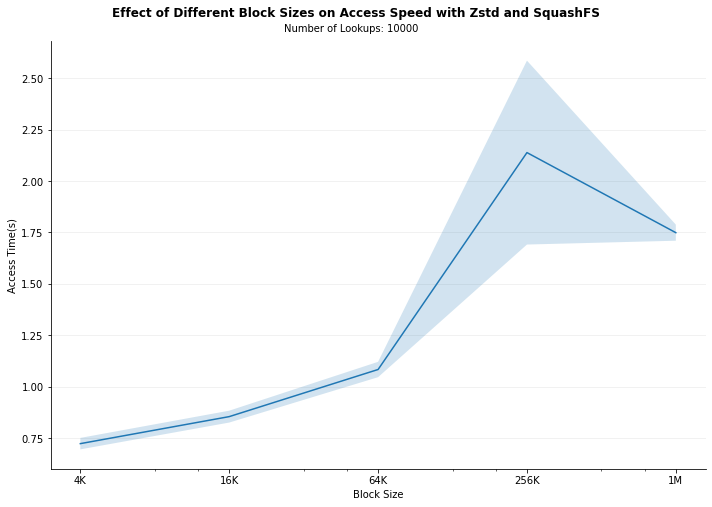

In [11]:
fig, ax = plt.subplots()

fig.suptitle("Effect of Different Block Sizes on Access Speed with Zstd and SquashFS", weight="bold", y=1)
fig.text(s=f"Number of Lookups: {NB_LOOKUPS}", y=0.95, x=0.4)

x = [pow(4,i) for i in range(1, 6)] # Array for ticks in X axis 

ax.semilogx(x, mean_df["mean"], base=4)
ax.fill_between(x, mean_df["mean"] - mean_df["std"], mean_df["mean"] + mean_df["std"], alpha=0.2)

ax.set_ylabel("Access Time(s)")
ax.set_xlabel("Block Size")
ax.set_xticks(x)
ax.set_xticklabels(block_sizes)

fig.tight_layout()
plt.show()